## Prepare module and drive
This training script will train model that have 3 types

In [1]:
import wandb
from wandb.keras import WandbCallback
import os
import warnings

import numpy as np
from matplotlib import pyplot as plt
import random

import librosa
import librosa.display
import aubio
import soundfile as sf
from soundfile import write
from numpy import vstack, zeros, diff

from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

## Functions

- dataloader

In [2]:
#time mask method
TMASK_MIN = 0
TMASK_MAX = 0.07
TLEN_MIN = 0.005
TLEN_MAX = 0.02

#frequency mask method
FMASK_MIN = 150
FMASK_MAX = 400
FLEN_MIN = 20
FLEN_MAX = 50


AUGMENTATION = 1 #for t_mask f_mask 決定mask數量
SR = 22050 #採樣率
N_FFT = 128 #Number of FFT Points A smaller N_FFT provides finer time resolution but coarser frequency resolution.
HOP_LENGTH = N_FFT / 4
# freq = librosa.fft_frequencies(sr=SR, n_fft=2048)
# print(freq)
# print(len(freq))
# print(freq[23])

In [72]:
# def dataloader(path, file, shift=False, noise=False, t_mask=False, f_mask=False, STFT_noise = False):
#     original_audio, sr = librosa.load(path + file)
#     audio_list = [original_audio]
    
#     #time shift
#     if shift:
#         audio_list.append(np.roll(original_audio, random.randint(1,1000)))
#         audio_list.append(np.roll(original_audio, random.randint(1001,2000)))
#         # audio_list.append(np.roll(original_audio, random.randint(-500,-1)))
    
#     #adding noise
#     if noise:
#         for i in range(len(audio_list)):
#             signal = audio_list[i]
#             SNR = random.uniform(15, 25)
#             # print(SNR)
#             Ps = np.sum(np.power(signal, 2)) / len(signal) #信號功率計算
#             Pn = Ps / (np.power(10, SNR / 10)) #噪音功率計算
#             noise_factor = np.sqrt(Pn)
#             white_noise = np.random.randn(len(signal)) * noise_factor
#             audio = signal + white_noise
#             audio_list.append(audio)
            
    
#     data_list = []
#     for audio in audio_list:
        
#         #normalization
#         normalize_data = audio / np.max(np.abs(audio), axis=0)
#         stfts = []
        
#         #stft
#         origin_stft = librosa.stft(y=normalize_data, n_fft=N_FFT)
#         stfts.append(origin_stft)
        
#         #time mask
#         if t_mask:
#             start_point = np.random.uniform(TMASK_MIN, TMASK_MAX, AUGMENTATION)
#             mask_len = np.random.uniform(TLEN_MIN, TLEN_MAX, AUGMENTATION)
#             # print(start_point, mask_len)
#             for i in range(AUGMENTATION):  
#                 t_mask_stft = origin_stft.copy()
#                 t_mask_stft[:, int(start_point[i] * SR / HOP_LENGTH):int((start_point[i] + mask_len[i]) * SR / HOP_LENGTH)] = 0
#                 stfts.append(t_mask_stft)
        
#         #frequency mask
#         if f_mask:
#             start_point = np.random.uniform(FMASK_MIN, FMASK_MAX, AUGMENTATION)
#             mask_len = np.random.uniform(FLEN_MIN, FLEN_MAX, AUGMENTATION)
#             print(start_point, mask_len)
#             for i in range(AUGMENTATION):
#                 f_mask_stft = origin_stft.copy()
#                 # findex = np.argwhere((freq > start_point[i]) & (freq < start_point[i] + mask_len[i]))
#                 findex = np.argwhere((freq > start_point[0]) & (freq < start_point[0] + mask_len[0]))
#                 print(findex)
#                 f_mask_stft[findex[0][0]:findex[len(findex)-1][0], :] = 0
#                 print(f_mask_stft.shape)
#                 stfts.append(f_mask_stft)
                
#         for stft in stfts: 
#             stft = librosa.amplitude_to_db(np.abs(stft),ref=np.max) #轉分貝
#             # fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
#             # img1 = librosa.display.specshow(stft, hop_length=64, x_axis='time', y_axis='log', ax=ax)
#             # ax.set(title='STFT (log scale)')
#             stft = stft[:, :, np.newaxis] #二維到三維拓展
#             stft /= np.max(np.abs(stft)) #歸一化
#             data_list.append(np.concatenate((stft, stft, stft), axis=2)) #模擬三通道圖像數據：才能適用模型訓練
#     return data_list

In [5]:
N_FFT = 128
HOP_LENGTH = 32
# image generation method for testing
# "melspectrogram", "raw", "mfcc_aubio", "mfcc_librosa", "stft"
image_gen_method = "mfcc_librosa"
audio_norm = False

def mySTFT(y, n_fft: int = 1024, hop_length = 128):
    z = np.copy(y)
    z = np.pad(z, (n_fft // 2, n_fft // 2), 'constant', constant_values=(0, 0))
    result_w = n_fft // 2 + 1
    result_h = len(y) // hop_length + 1
    result = np.zeros(shape=(result_h, result_w))
    hann = np.hanning(n_fft)
    for i in range(result_h):
        tmp = np.fft.rfft(z[i * hop_length: i * hop_length + n_fft] * hann)
        # print(len(tmp))
        for j in range(result_w):
            result[i][j] = abs(tmp[j])
    return result
            
def randomSTFT(y):
    result = np.zeros(shape=(len(y), len(y[0])))
    for i in range(len(y)):
        for j in range(len(y[0])):
            result[i][j] = random.random() * 0.2 + y[i][j]
    return result
    
# mask 先不用
def dataloader(path, file, shift=False, noise=False, t_mask=False, f_mask=False, STFT_noise=False):
    # 讀取原始音訊數據
    original_audio, sr = librosa.load(path + file)
    audio_list = [original_audio]

    # 隨機平移數據擴增 p36
    if shift:
        audio_list.append(np.roll(original_audio, random.randint(1,1000)))
        audio_list.append(np.roll(original_audio, random.randint(1001,2000)))
        # audio_list.append(np.roll(original_audio, random.randint(-500,-1)))

    # 噪音數據擴增 p37
    if noise:
        for i in range(len(audio_list)):
            signal = audio_list[i]
            SNR = random.uniform(15, 25)
            # print(SNR)
            Ps = np.sum(np.power(signal, 2)) / len(signal)
            Pn = Ps / (np.power(10, SNR / 10))
            noise_factor = np.sqrt(Pn)
            white_noise = np.random.randn(len(signal)) * noise_factor
            audio = signal + white_noise
            audio_list.append(audio)

    features = []
    # 遍歷每個音頻文件
    for audio in audio_list:
        # 提取MFCC特徵
        if audio_norm == True:
            audio = audio / np.max(np.abs(audio), axis=0)
        if image_gen_method == "melspectrogram":
            spectro = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024))
            spectro /= np.max(np.abs(spectro))
            features.append(spectro)
        elif image_gen_method == "mfcc_librosa":
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=60, hop_length=64)
            #mfcc = librosa.feature.mfcc(y=audio, sr=sr, norm=None)
            mfcc = mfcc / np.max(np.abs(mfcc), axis=0)
            features.append(mfcc)
        elif image_gen_method == "mfcc_aubio":
            win_s = 1024
            hop_s = 128
            n_filters = 40
            n_coeffs = 65
            mfccs = zeros([n_coeffs,])
            p = aubio.pvoc(win_s, hop_s)
            m = aubio.mfcc(win_s, n_filters, n_coeffs, sr)
            audio_idx = 0
            audio = audio.astype('float32')
            print(max(audio))
            while True:
                spec = p(audio[audio_idx: audio_idx + hop_s])
                mfcc_out = m(spec)
                mfcc_out = mfcc_out / np.max(np.abs(mfcc_out), axis=0)
                mfccs = vstack((mfccs, mfcc_out))
                audio_idx += hop_s
                if audio_idx > len(audio) - hop_s: break
            mfccs /= np.max(np.abs(mfccs))
            features.append(mfccs)
            # aubio.mfcc(buf_size=1024, n_filters=40, n_coeffs=13, samplerate=44100)
        elif image_gen_method == "stft":
            # stft = librosa.stft(y=audio, n_fft=1024, hop_length=128)
            stft = mySTFT(y=audio, n_fft=1024, hop_length=128)
            stft = np.abs(stft)
            stft /= np.max(np.abs(stft))
            features.append(stft)
            if STFT_noise == True:
                features.append(randomSTFT(stft))
                features.append(randomSTFT(stft))
        elif image_gen_method == "stft_old":
            stft = librosa.stft(y=audio, n_fft=128, hop_length=32)
            # stft = mySTFT(y=audio, n_fft=128, hop_length=32)
            stft = np.abs(stft)
            stft /= np.max(np.abs(stft))
            features.append(stft)
            if STFT_noise == True:
                features.append(randomSTFT(stft))
                features.append(randomSTFT(stft))
        elif image_gen_method == "raw":
            features.append(audio)
            # Input(shape=(X_train.shape[1])),

    return features

In [3]:
# mfcc result printer

# test_audio, sr = librosa.load("./PA_sound_normalize/20240511_phone/drum/drum0_0.wav") 
# print(max(test_audio))
# # mfcc = librosa.feature.mfcc(y=test_audio, sr=sr, n_mfcc=60, hop_length=64)
# mfcc = librosa.feature.mfcc(y=test_audio, sr=sr, n_mels=128)

# print(mfcc)
# mfcc = mfcc / np.max(np.abs(mfcc), axis=0)

# stft result
test_audio, sr = librosa.load("./PA_sound_normalize/20240511_phone/drum/drum0_0.wav")
# print(max(test_audio))
# print(test_audio[0:8])
# print(np.fft.rfft(test_audio[0:1024]))
# origin_stft = librosa.stft(y=test_audio, n_fft=1024, hop_length=128)
origin_stft = mySTFT(y=test_audio, n_fft=1024, hop_length=128)
origin_stft /= np.max(origin_stft)
print(origin_stft)

[[0.01648582 0.01900818 0.05903508 ... 0.00185016 0.00211154 0.00178479]
 [0.01762229 0.00432757 0.087982   ... 0.00916009 0.01054156 0.01062439]
 [0.00106062 0.02164529 0.11845702 ... 0.01957028 0.02212759 0.02271729]
 ...
 [0.00369735 0.00823158 0.0532215  ... 0.00243122 0.00087248 0.00153017]
 [0.00343356 0.00597678 0.05287816 ... 0.00225437 0.00110939 0.00015992]
 [0.00694383 0.00926696 0.04211648 ... 0.00194667 0.00141773 0.00058374]]


## Get Data

- features : call dataLoader
- labels:
    - 0 : meat
    - 1 : drum
    - 2 : column


In [6]:
# ceramics_paths = ["./data/cutData/ceramics/"]
# drum_paths = ["../cup/data/cutData/metal/"]
# col_paths = ["../cup/data/cutData/plastic/"]
# meat_paths = ["../cup/data/cutData/glass/"]

# drum_paths = ["./PA_sound_normalize/20240511_phone/drum/"]
# col_paths = ["./PA_sound_normalize/20240511_phone/column/"]
# meat_paths = ["./PA_sound_normalize/20240511_phone/meat/"]

drum_paths = ["../../bowen/phone_model/data/20240511_phone/drum/"]
col_paths = ["../../bowen/phone_model/data/20240511_phone/column/"]
meat_paths = ["../../bowen/phone_model/data/20240511_phone/meat/"]

audio_aug = True

train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []

# --------------------------------------------------------------------------
for drum_path in drum_paths:
    files = os.listdir(drum_path)
    print("#Files : " + str(len(files)))

    # 打乱文件列表
    random.shuffle(files)

    # 分割文件列表，70%用于训练，10%用于验证，20%用于测试
    total_files = len(files)
    train_split_index = int(0.7 * total_files)
    val_split_index = int(0.8 * total_files)

    train_files = files[:train_split_index]
    val_files = files[train_split_index:val_split_index]
    test_files = files[val_split_index:]

    # 加载训练数据
    for file in train_files:
        try:
            data_list = dataloader(drum_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in data_list:
                train_features.append(data)
                train_labels.append(1)
        except Exception as e:
            print(f"Error processing training file {file}: {e}")
            continue

    # 加载验证数据
    for file in val_files:
        try:
            val_data_list = dataloader(drum_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in val_data_list:
                val_features.append(data)
                val_labels.append(1)
        except Exception as e:
            print(f"Error processing validation file {file}: {e}")
            continue

    # 加载测试数据
    for file in test_files:
        try:
            test_data_list = dataloader(drum_path, file, shift=False, noise=False)
            for data in test_data_list:
                test_features.append(data)
                test_labels.append(1)
        except Exception as e:
            print(f"Error processing test file {file}: {e}")
            continue

    print("Length of training features:", len(train_features))
    print("Length of validation features:", len(val_features))
    print("Length of test features:", len(test_features))

# --------------------------------------------------------------------------

for col_path in col_paths:
    files = os.listdir(col_path)
    print("#Files : " + str(len(files)))

    # 打乱文件列表
    random.shuffle(files)

    # 分割文件列表，70%用于训练，10%用于验证，20%用于测试
    total_files = len(files)
    train_split_index = int(0.7 * total_files)
    val_split_index = int(0.8 * total_files)

    train_files = files[:train_split_index]
    val_files = files[train_split_index:val_split_index]
    test_files = files[val_split_index:]

    # 加载训练数据
    for file in train_files:
        try:
            data_list = dataloader(col_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in data_list:
                train_features.append(data)
                train_labels.append(2)
        except Exception as e:
            print(f"Error processing training file {file}: {e}")
            continue

    # 加载验证数据
    for file in val_files:
        try:
            val_data_list = dataloader(col_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in val_data_list:
                val_features.append(data)
                val_labels.append(2)
        except Exception as e:
            print(f"Error processing validation file {file}: {e}")
            continue

    # 加载测试数据
    for file in test_files:
        try:
            test_data_list = dataloader(col_path, file, shift=False, noise=False)
            for data in test_data_list:
                test_features.append(data)
                test_labels.append(2)
        except Exception as e:
            print(f"Error processing test file {file}: {e}")
            continue

    print("Length of training features:", len(train_features))
    print("Length of validation features:", len(val_features))
    print("Length of test features:", len(test_features))

# --------------------------------------------------------------------------
for meat_path in meat_paths:
    files = os.listdir(meat_path)
    print("#Files : " + str(len(files)))

    # 打乱文件列表
    random.shuffle(files)

    # 分割文件列表，70%用于训练，10%用于验证，20%用于测试
    total_files = len(files)
    train_split_index = int(0.7 * total_files)
    val_split_index = int(0.8 * total_files)

    train_files = files[:train_split_index]
    val_files = files[train_split_index:val_split_index]
    test_files = files[val_split_index:]

    # 加载训练数据
    for file in train_files:
        try:
            data_list = dataloader(meat_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in data_list:
                train_features.append(data)
                train_labels.append(0)
        except Exception as e:
            print(f"Error processing training file {file}: {e}")
            continue

    # 加载验证数据
    for file in val_files:
        try:
            val_data_list = dataloader(meat_path, file, shift=audio_aug, noise=audio_aug, STFT_noise=True)
            for data in val_data_list:
                val_features.append(data)
                val_labels.append(0)
        except Exception as e:
            print(f"Error processing validation file {file}: {e}")
            continue

    # 加载测试数据
    for file in test_files:
        try:
            test_data_list = dataloader(meat_path, file, shift=False, noise=False)
            for data in test_data_list:
                test_features.append(data)
                test_labels.append(0)
        except Exception as e:
            print(f"Error processing test file {file}: {e}")
            continue

    print("Length of training features:", len(train_features))
    print("Length of validation features:", len(val_features))
    print("Length of test features:", len(test_features))



#Files : 785
Length of training features: 3294
Length of validation features: 474
Length of test features: 157
#Files : 630
Length of training features: 5940
Length of validation features: 852
Length of test features: 283
#Files : 417
Length of training features: 7686
Length of validation features: 1104
Length of test features: 367


In [5]:
# Some elements maybe wrong?
filtered_image_list = []
filtered_label_list = []


for image, label in zip(train_features, train_labels):
    if image.shape == (18, 513):
        filtered_image_list.append(image)
        filtered_label_list.append(label)
    else:
        print(f"{image.shape} be skipped.")
# -------------------------------------------------------------------------------------

X_train = np.array(filtered_image_list)
y_train = np.array(filtered_label_list)

In [6]:
# Some elements maybe wrong?
filtered_image_list = []
filtered_label_list = []

for image, label in zip(val_features, val_labels):
    if image.shape == (18,513):
        filtered_image_list.append(image)
        filtered_label_list.append(label)
    else:
        print(f"{image.shape} be skipped.")
# -------------------------------------------------------------------------------------

X_val = np.array(filtered_image_list)
y_val = np.array(filtered_label_list)

In [7]:
# Some elements maybe wrong?
filtered_image_list = []
filtered_label_list = []

for image, label in zip(test_features, test_labels):
    if image.shape == (18,513):
        filtered_image_list.append(image)
        filtered_label_list.append(label)
    else:
        print(f"{image.shape} be skipped.")
# -------------------------------------------------------------------------------------

X_test = np.array(filtered_image_list)
y_test = np.array(filtered_label_list)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15120, 18, 513)
(15120,)
(2178, 18, 513)
(2178,)
(241, 18, 513)
(241,)


In [10]:
# encode => one-hot
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)

y_val_encoded = label_encoder.fit_transform(y_val)
y_val_onehot = to_categorical(y_val_encoded)

y_test_encoded = label_encoder.fit_transform(y_test)
y_test_onehot = to_categorical(y_test_encoded)

## WanDB

In [22]:
DATASET = "manual"    # "auto or "manual"
DATE = "20240926"
MODEL = "NN"
VERSION = "0.0.1"

lr = 0.0001
epochs = 50
batch_size = 64
decay = 0.001

## Training

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from wandb.integration.keras import WandbMetricsLogger
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16


In [57]:

# 調整輸入形狀以適應 CNN (添加通道維度)
X_train = X_train.reshape(-1, 513, 18, 1)
X_val = X_val.reshape(-1, 513, 18, 1)
X_test = X_test.reshape(-1, 513, 18, 1)

# 構建 CNN 模型
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(513, 18, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# 使用 Adam 優化器
adam = Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# 定義回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = f"./checkpoint/model_checkpoint.ckpt"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

callbacks = [early_stopping]

# 訓練模型
history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=128, validation_data=(X_val, y_val_onehot), callbacks=callbacks)

# 在測試集上評估模型
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"測試損失: {loss}, 測試準確度: {accuracy}")



Epoch 1/50
181/181 [==============================] - 2s 10ms/step - loss: 0.9061 - accuracy: 0.5427 - val_loss: 0.8223 - val_accuracy: 0.5830
Epoch 2/50
181/181 [==============================] - 2s 8ms/step - loss: 0.7450 - accuracy: 0.6585 - val_loss: 0.7232 - val_accuracy: 0.6673
Epoch 3/50
181/181 [==============================] - 2s 8ms/step - loss: 0.6713 - accuracy: 0.7008 - val_loss: 0.6781 - val_accuracy: 0.6866
Epoch 4/50
181/181 [==============================] - 2s 8ms/step - loss: 0.6270 - accuracy: 0.7180 - val_loss: 0.6662 - val_accuracy: 0.6932
Epoch 5/50
181/181 [==============================] - 2s 8ms/step - loss: 0.5927 - accuracy: 0.7399 - val_loss: 0.6629 - val_accuracy: 0.7098
Epoch 6/50
181/181 [==============================] - 2s 9ms/step - loss: 0.5630 - accuracy: 0.7612 - val_loss: 0.6353 - val_accuracy: 0.7147
Epoch 7/50
181/181 [==============================] - 2s 8ms/step - loss: 0.5355 - accuracy: 0.7737 - val_loss: 0.6064 - val_accuracy: 0.7331
Epoch

### Ver 1.0.0 RNN


In [42]:
# X : features ，y : label（'Drum sound' or 'Meat sound'）

# encode => one-hot
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# y_onehot = to_categorical(y_encoded)

# # split
# X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# define model
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0005, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# train model
model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(X_val, y_val_onehot),
          callbacks=[early_stopping])

# evaluate
loss, accuracy = model.evaluate(X_val, y_val_onehot)
print(f"測試損失: {loss}, 測試準確度: {accuracy}")

# prediction
# predictions = model.predict(X_test)

Epoch 1/50
241/241 [==============================] - 3s 13ms/step - loss: 1.0620 - accuracy: 0.4562 - val_loss: 1.0371 - val_accuracy: 0.4737
Epoch 2/50
241/241 [==============================] - 3s 12ms/step - loss: 1.0318 - accuracy: 0.4940 - val_loss: 1.0314 - val_accuracy: 0.4828
Epoch 3/50
241/241 [==============================] - 3s 12ms/step - loss: 1.0126 - accuracy: 0.5052 - val_loss: 1.0320 - val_accuracy: 0.4665
Epoch 4/50
241/241 [==============================] - 3s 12ms/step - loss: 1.0023 - accuracy: 0.5070 - val_loss: 1.0146 - val_accuracy: 0.4819
Epoch 5/50
241/241 [==============================] - 3s 12ms/step - loss: 0.9875 - accuracy: 0.5167 - val_loss: 1.0133 - val_accuracy: 0.5118
Epoch 6/50
241/241 [==============================] - 3s 12ms/step - loss: 0.9726 - accuracy: 0.5323 - val_loss: 1.0209 - val_accuracy: 0.4801
Epoch 7/50
241/241 [==============================] - 3s 13ms/step - loss: 0.9620 - accuracy: 0.5385 - val_loss: 0.9823 - val_accuracy: 0.5217

### Ver 2.0.0 LTSM

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

# X : features ，y : label（'Drum sound' or 'Meat sound'）

# # encode => one-hot
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# y_onehot = to_categorical(y_encoded)

# X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
# print(y_train[0])
# define model
model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', recurrent_dropout=0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(y_train_onehot.shape[1], activation='softmax')
])
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0005, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# TODO:
# Create callbacks:
# 1. early stopping (with a patience of 5 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
# 2. model checkpointing
#checkpoint_path = f"../checkpoint/{MODEL}/{DATE}_{MODEL}_v{VERSION}.ckpt"
#model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
# 3. learning rate reduction on plateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
#           callbacks=[WandbCallback(), early_stopping, model_checkpoint, reduce_lr])


# train model
model.fit(X_train, y_train_onehot, epochs=300, batch_size=32, validation_data=(X_val, y_val_onehot),
          callbacks=[early_stopping])

# evaluate
loss, accuracy = model.evaluate(X_val, y_val_onehot)
print(f"測試損失: {loss}, 測試準確度: {accuracy}")


Epoch 1/300
241/241 [==============================] - 6s 23ms/step - loss: 1.0504 - accuracy: 0.4452 - val_loss: 1.0149 - val_accuracy: 0.5308
Epoch 2/300
241/241 [==============================] - 5s 23ms/step - loss: 0.8975 - accuracy: 0.5805 - val_loss: 0.8497 - val_accuracy: 0.6123
Epoch 3/300
241/241 [==============================] - 5s 23ms/step - loss: 0.7750 - accuracy: 0.6586 - val_loss: 0.7513 - val_accuracy: 0.6694
Epoch 4/300
241/241 [==============================] - 5s 22ms/step - loss: 0.7205 - accuracy: 0.6868 - val_loss: 0.6955 - val_accuracy: 0.7020
Epoch 5/300
241/241 [==============================] - 5s 22ms/step - loss: 0.6829 - accuracy: 0.7015 - val_loss: 0.7326 - val_accuracy: 0.6821
Epoch 6/300
241/241 [==============================] - 5s 23ms/step - loss: 0.6644 - accuracy: 0.7087 - val_loss: 0.6891 - val_accuracy: 0.7083
Epoch 7/300
241/241 [==============================] - 5s 22ms/step - loss: 0.6507 - accuracy: 0.7187 - val_loss: 0.6339 - val_accuracy:

In [39]:


# X : features ，y : label（'Drum sound' or 'Meat sound'）

#X_train1, X_val, y_train_onehot1, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.1, random_state=42)


# define model
# model = Sequential([
#     Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(512, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
#     Dropout(0.1),
#     Dense(y_onehot.shape[1], activation='softmax')
# ])
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_2'),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# TODO:
# Create callbacks:
# 1. early stopping (with a patience of 5 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 2. model checkpointing
#checkpoint_path = f"../checkpoint/{MODEL}/{DATE}_{MODEL}_v{VERSION}.ckpt"
#model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
# 3. learning rate reduction on plateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
#           callbacks=[WandbCallback(), early_stopping, model_checkpoint, reduce_lr])


# train model
model.fit(X_train, y_train_onehot, epochs=500, batch_size=batch_size, validation_data=(X_val, y_val_onehot),
          callbacks=[early_stopping])

# evaluate
loss, accuracy = model.evaluate(X_val, y_val_onehot)
print(f"測試損失: {loss}, 測試準確度: {accuracy}")


Epoch 1/500
237/237 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8574 - val_loss: 0.3505 - val_accuracy: 0.8792
Epoch 2/500
237/237 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9212 - val_loss: 0.3630 - val_accuracy: 0.8669
Epoch 3/500
237/237 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9376 - val_loss: 0.3526 - val_accuracy: 0.8838
Epoch 4/500
237/237 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.9468 - val_loss: 0.3569 - val_accuracy: 0.8733
Epoch 5/500
237/237 [==============================] - 0s 2ms/step - loss: 0.1287 - accuracy: 0.9524 - val_loss: 0.3989 - val_accuracy: 0.8710
Epoch 6/500
237/237 [==============================] - 0s 2ms/step - loss: 0.1065 - accuracy: 0.9597 - val_loss: 0.3596 - val_accuracy: 0.8898
Epoch 7/500
237/237 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.9653 - val_loss: 0.4385 - val_accuracy: 0.8976

In [40]:
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"測試損失: {loss}, 測試準確度: {accuracy}")

8/8 [==============================] - 0s 1ms/step - loss: 0.1004 - accuracy: 0.9627
測試損失: 0.10038008540868759, 測試準確度: 0.9626556038856506


In [21]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout
# from tensorflow.keras.optimizers import Adam, SGD
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from sklearn.model_selection import train_test_split
# from keras.regularizers import l2

# # X : features ，y : label（'Drum sound' or 'Meat sound'）

# # encode => one-hot
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# y_onehot = to_categorical(y_encoded)

# X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=40)
# X_train = X_train[..., np.newaxis]
# y_train = y_train[..., np.newaxis]
# print(y_train.shape)
# # define model
# model = Sequential([
#     Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=(5, 60, 1)),
#     Conv2D(192, (2, 2)),
#     Activation('relu'),
#     Conv2D(32, (2, 2)),
#     Activation('relu'),
#     # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
#     Dropout(0.25),
#     # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
#     Flatten(),
#     # 全連接層: 128個output
#     Dense(128, activation='relu'),
#     Dropout(0.25),
#     # Add output layer
#     Dense(2, activation='softmax')
# ])
# adam = Adam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# # TODO:
# # Create callbacks:
# # 1. early stopping (with a patience of 5 epochs)
# early_stopping = EarlyStopping(monitor='val_loss', patience=50)
# # 2. model checkpointing
# checkpoint_path = f"../checkpoint/{MODEL}/{DATE}_{MODEL}_v{VERSION}.ckpt"
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
# # 3. learning rate reduction on plateau
# # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# # model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
# #           callbacks=[WandbCallback(), early_stopping, model_checkpoint, reduce_lr])


# # train model
# model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_test, y_test),
#           callbacks=[early_stopping, model_checkpoint])

# # evaluate
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"測試損失: {loss}, 測試準確度: {accuracy}")

## Test

In [41]:
import seaborn as sns

In [42]:
y_pred = model.predict(X_test)

y_pred_1 = []
y_test_1 = []
for i in y_pred:
    max_id = 0
    max_val = 0
    for j in range(2):
        if i[j] > 0.5:
            max_id = j
            max_val = i[j]
    y_pred_1.append(max_id)

for i in y_test_onehot:
    max_id = 0
    max_val = 0
    for j in range(2):
        if max_val < i[j]:
            max_id = j
            max_val = i[j]
    y_test_1.append(max_id)


# print(y_test_1, y_pred, y_pred_1)
# rounded_labels=np.argmax(y_test_1, axis=1)
cf_matrix = confusion_matrix(y_test_1, y_pred_1)

測試損失: 0.46602320671081543, 測試準確度: 0.8228882551193237


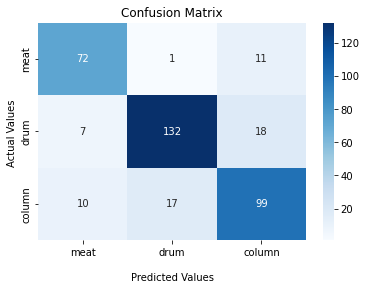

In [56]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['meat','drum', 'column'])
ax.yaxis.set_ticklabels(['meat','drum', 'column'])

print(f"測試損失: {loss}, 測試準確度: {accuracy}")

## Display the visualization of the Confusion Matrix.
plt.show()

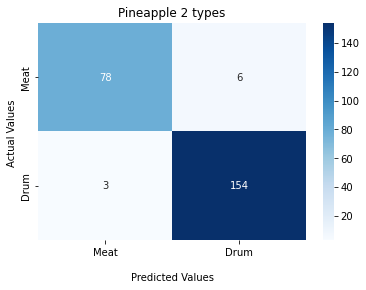

In [43]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Pineapple 2 types')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['Meat','Column','Drum'])
# ax.yaxis.set_ticklabels(['Meat','Column','Drum'])
# ax.xaxis.set_ticklabels(['Meat','Column','Drum', 'Unidentified'])
# ax.yaxis.set_ticklabels(['Meat','Column','Drum', 'Unidentified'])
ax.xaxis.set_ticklabels(['Meat','Drum'])
ax.yaxis.set_ticklabels(['Meat','Drum'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Save model

In [44]:
# save model (h5)
from tensorflow.keras.models import Sequential, save_model, load_model

filepath = f"./model/"
if not os.path.isdir(filepath):
    os.makedirs(filepath)
save_model(model, filepath + f"{DATE}_{MODEL}_v{VERSION}", save_format='h5')

In [45]:
# save model (pb)
filepath = f"./model/pb/{DATE}_{MODEL}_v{VERSION}"
if not os.path.isdir(filepath):
    os.makedirs(filepath)
model.save(filepath)

INFO:tensorflow:Assets written to: ./model/pb/20240926_NN_v0.0.1/assets


INFO:tensorflow:Assets written to: ./model/pb/20240926_NN_v0.0.1/assets


In [46]:
# convert pb model to tflite model
# saved_model_dir = '../../../model/20230325_auto/pb/20230325_VGG16_v2/'
converter = tf.lite.TFLiteConverter.from_saved_model(filepath)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open(f"./model/{DATE}_{MODEL}_v{VERSION}.tflite", 'wb').write(tflite_model)
# open(filepath + ".tflite", 'wb').write(tflite_model)

2024-09-26 21:39:15.559614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2024-09-26 21:39:15.559635: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2024-09-26 21:39:15.559639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2024-09-26 21:39:15.559729: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./model/pb/20240926_NN_v0.0.1
2024-09-26 21:39:15.561067: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2024-09-26 21:39:15.561076: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./model/pb/20240926_NN_v0.0.1
2024-09-26 21:39:15.566099: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2024-09-26 21:39:15.605301: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at 

9525728

In [47]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=f"./model/{DATE}_{MODEL}_v{VERSION}.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details[0]['shape'])
print(output_details[0]['shape'])

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[  1  18 513]
[1 2]
[[0.99843675 0.00156322]]


In [30]:
import onnx

# 加载 ONNX 模型
model = onnx.load("./pine1.onnx")

# 获取图的第一个输入节点
model.graph.input[0].name = 'input_2:0'  # 将 input_1 改为 input_2

# 保存修改后的 ONNX 模型
onnx.save(model, "./pine.onnx")


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

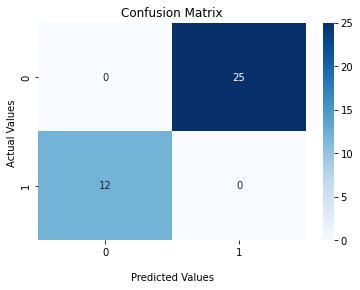

In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = []
num = 0
for data in X_test:
    data = np.float32(data)
    interpreter.set_tensor(input_details[0]['index'], [data])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    num += 1
    if output_data[0][0] >= 0.7:
        y_pred.append(1)
    else:
        y_pred.append(0)
    #print(y_pred)



cf_matrix = confusion_matrix(y_test_1, y_pred)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Meat', 'Column', 'Drum'])
ax.yaxis.set_ticklabels(['Meat', 'Column', 'Drum'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
!pip install pydot graphviz


/bin/bash: pip: command not found


In [7]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Define the model
model = Sequential([
    Input(shape=(100, 10), name='input_2'),  # Replace (100, 10) with your input shape
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Replace 10 with the number of classes in your problem
])

# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)
plt.show()


ImportError: cannot import name 'plot_model' from 'keras.utils' (/home/hsnl-iot/anaconda3/envs/seedenv/lib/python3.9/site-packages/keras/utils/__init__.py)